In [20]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
out_folder = '/nobackup/turaga/singhc/par_zwshed/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16

In [21]:
f = h5py.File(pred_file, 'r') # only key is main
preds = f['main']
print preds.shape

(3, 125, 1250, 1250)


# Divide Volumes, set up args

In [22]:
def zwshed_h5_par(arg):
    (pred_vol,threshes,seg_save_path) = arg
    print "calculating",seg_save_path,"watershed"
    zwatershed_h5(pred_vol, threshes,seg_save_path)
    print "finished",seg_save_path,"watershed"
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'/'

In [23]:
MAX_LEN = 400
dims = np.array((preds.shape[1:]))
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts = []
ends = []
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas)
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra)
args = []
for i in range(len(starts)):
    s = starts[i]
    e = ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print s,e,pred_vol.shape
    args.append((pred_vol,threshes,out_folder+dim_to_name(s)))    

dims [ 125 1250 1250]
num_vols [1 4 4]
deltas [125 312 312]
[0 0 0] [129 313 313] (3, 125, 313, 313)
[  0   0 312] [129 313 625] (3, 125, 313, 313)
[  0   0 624] [129 313 937] (3, 125, 313, 313)
[  0   0 936] [ 129  313 1252] (3, 125, 313, 314)
[  0 312   0] [129 625 313] (3, 125, 313, 313)
[  0 312 312] [129 625 625] (3, 125, 313, 313)
[  0 312 624] [129 625 937] (3, 125, 313, 313)
[  0 312 936] [ 129  625 1252] (3, 125, 313, 314)
[  0 624   0] [129 937 313] (3, 125, 313, 313)
[  0 624 312] [129 937 625] (3, 125, 313, 313)
[  0 624 624] [129 937 937] (3, 125, 313, 313)
[  0 624 936] [ 129  937 1252] (3, 125, 313, 314)
[  0 936   0] [ 129 1252  313] (3, 125, 314, 313)
[  0 936 312] [ 129 1252  625] (3, 125, 314, 313)
[  0 936 624] [ 129 1252  937] (3, 125, 314, 313)
[  0 936 936] [ 129 1252 1252] (3, 125, 314, 314)


# Call Watershed

In [24]:
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)

calculating /nobackup/turaga/singhc/par_zwshed/0_0_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_312/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_624/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_0_936/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_312_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_312_312/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_312_624/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_312_936/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_624_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_624_312/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_624_624/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_624_936/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_936_0/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_936_312/ watershed
calculating /nobackup/turaga/singhc/par_zwshed/0_936_624/ waters

IOError: Unable to create file (Unable to truncate a file which is already open)

# Stitch

merging numbers, 1013 keys ... 
	nsegs before 12704
	nsegs after 11691
	renumbering all... 12703
	num segs 11690


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


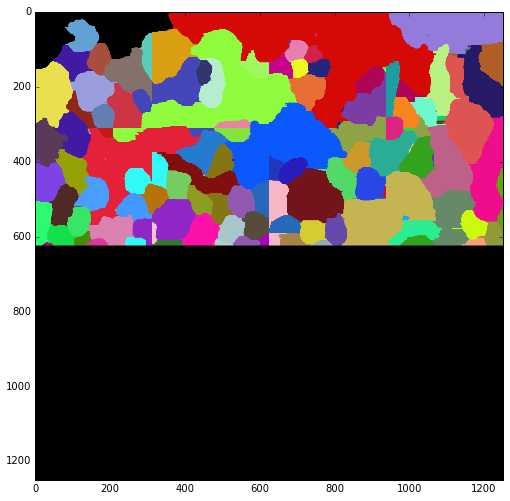

In [64]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
i = 0
# zbars = {}
for x in range(1): #num_vols[0]):
    i = x*num_vols[0]*num_vols[1]
    xdim = deltas[0]+1
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')
    for y in range(2): #num_vols[1]):
        i = x*num_vols[0]*num_vols[1]+y*num_vols[1]
        ydim = deltas[1]+1
        if y==num_vols[1]-1:
            xdim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        renums = {} # maxes -> mins
        sy = starts[i]
        ey = ends[i]
        '''
        for z in range(4): #num_vols[2]):  # merge along z axis - fills in zbar
            i = x*num_vols[0]*num_vols[1]+y*num_vols[1]+z
            inc_max = np.max(zbar)
            arg = args[i]
            s = starts[i]
            e = ends[i]
            filename = 'seg_2000.h5'
            seg_h5 = h5py.File(arg[2]+filename,'r')
            seg = seg_h5['main']+inc_max
            print "\t",s,e,seg.shape, np.max(zbar)
            
            if z==0: # don't merge
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            else: # merge
                edge_mins = zbar[:,:,s[2]].flatten()
                edge_maxes = seg[:,:,0].flatten()                
                renums = calc_renums(edge_mins,edge_maxes)
                
                zbar[:,:,s[2]:e[2]] = seg[:,:,:]
        zbar = merge_and_renum(renums,zbar)
        zbars[y]=zbar
        '''
        zbar = zbars[y]
        inc_max = np.max(ybar)
        zbar = zbar+inc_max
        if y==0: # don't merge
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]
        else: # merge
            edge_mins = ybar[:,s[1],:].flatten()
            edge_maxes = zbar[:,0,:].flatten()
            renums = calc_renums(edge_mins,edge_maxes)
            ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]
    ybar = merge_and_renum(renums,ybar)
    display_seg_yz(ybar,1)

seg_out = np.zeros(dims,dtype='uint64') # x,y,z   

In [60]:
def calc_renums(edge_mins,edge_maxes):
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_max==edge_min:

#                         if edge_max in renums: # already in map
#                             old_min = renums[edge_max]
#                             merge_max = max(old_min,edge_min)
#                             merge_min = min(old_min,edge_min)
#                             if not merge_max==merge_min:
#                                 renums[merge_max] = merge_min  

            renums[edge_max] = edge_min
    return renums
    
def merge_and_renum(renums,zbar):
    # merge numbers
    renums2 = {}
    print "merging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        while val in renums:
            val = renums[val]
        renums2[key] = val

    print "\tnsegs before",len(np.unique(zbar))
#     display_seg_yz(zbar,1)
    mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
    mp[renums2.keys()] = renums2.values()
    zbar = mp[zbar]
    print "\tnsegs after",len(np.unique(zbar))
#         display_seg_yz(zbar,1)

    # renumber all
    print "\trenumbering all...",np.max(zbar)
    zbar,seg_sizes = prune_and_renum(zbar,0)
    print "\tnum segs",np.max(zbar)
    # zbars[(x,y)] = zbar  
#     display_seg_yz(zbar,1)
    return zbar

# Visualize

In [136]:
for arg in args:
    for filename in os.listdir(arg[2]):
        seg_h5 = h5py.File(arg[2]+filename,'r')
        seg = seg_h5['main']
        print arg[2],seg.shape

/nobackup/turaga/singhc/par_zwshed/0_0_0/ (125, 313, 313)
/nobackup/turaga/singhc/par_zwshed/0_0_312/ (125, 313, 313)


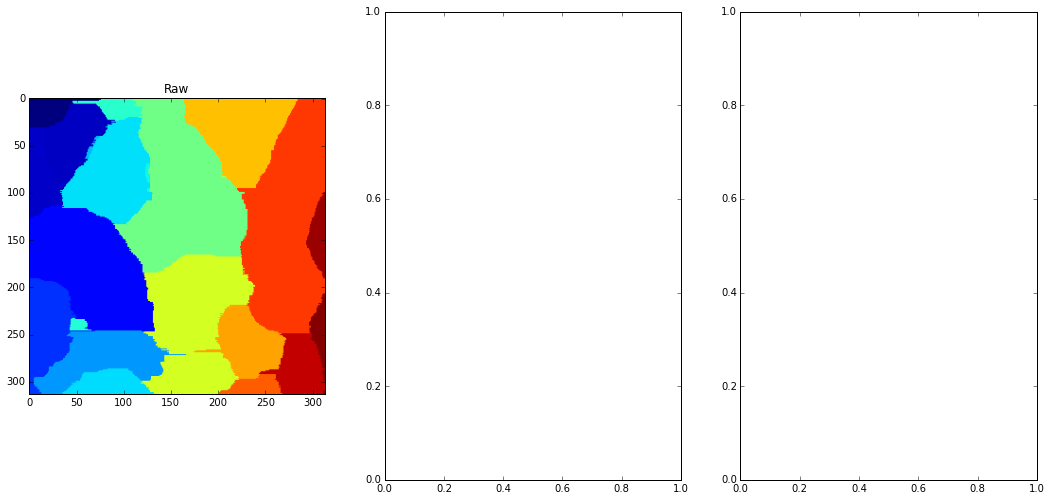

In [65]:
def display_affs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    ax1.set_title('Raw')
    plt.show()
def display_segs(raw, label, seg):
    fig = plt.figure(figsize=(20, 10))
    fig.set_facecolor('white')
    ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[1, :, :])
    ax1.set_title('Raw')
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def prune_and_renum(seg,sizeThreshold=1):
    # renumber the components in descending order by size
    segId,segSizes = np.unique(seg, return_counts=True)
    renum = np.zeros(segId.max()+1,dtype=np.int32)
    renum[segId] = np.arange(0,len(segId)+1)

    if sizeThreshold>0:
        renum[segId[segSizes<=sizeThreshold]] = 0
        segSizes = segSizes[segSizes>sizeThreshold]

    seg = renum[seg]
    return (seg, segSizes)
# display_arbitrary(preds,preds,preds)
display_segs(seg,seg,seg)